In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import corner
import jax.numpy as jnp
from opt_einsum import contract
from jax.config import config
import jax
import sys
sys.path.append("..")
from src.reparameterization import reparameterization, logit, logistic_CDF, sigma_inv

config.update("jax_enable_x64", True)

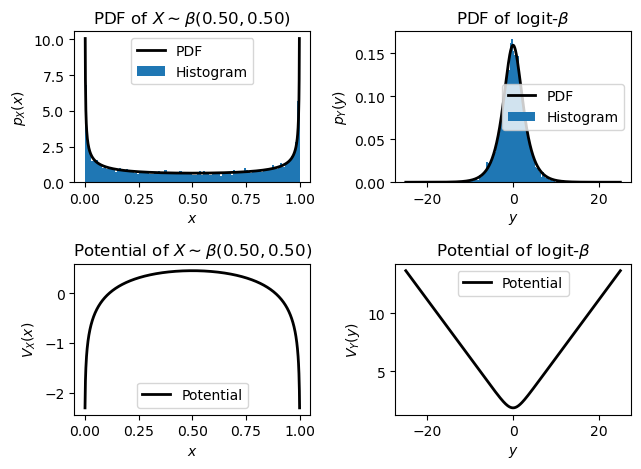

In [2]:
""" 
References
----------

(1) https://stats.stackexchange.com/questions/286042/derivation-of-the-mean-and-variance-of-the-logit-transform-of-a-beta-random-vari

"""

# Define a beta distributed random variable
alpha = 0.5
beta = 0.5
rv = scipy.stats.beta(alpha, beta)
beta_samples = rv.rvs(size=10000)

# Definitions needed for transformationj
B = scipy.special.beta(alpha, beta) # Normalization constant

logit_beta_pdf = lambda x: ((1/B) * logistic_CDF(x) ** alpha * (1 - logistic_CDF(x)) ** beta).squeeze()


# logit_beta_pdf = lambda x: (1/B) * logistic_CDF(x) ** alpha * (1 - logistic_CDF(x)) ** beta
logit_beta_samples = logit(beta_samples)

# Plot the PDF of the beta rv and its histogram
fig, ax = plt.subplots(2,2)
x = np.linspace(0, 1, 1000)
beta_pdf_values = rv.pdf(x)
ax[0, 0].plot(x, beta_pdf_values, 'k-', lw=2, label='PDF')
ax[0, 0].hist(beta_samples, density=True, bins=100, label='Histogram')
ax[0, 0].set_xlabel(r'$x$')
ax[0, 0].set_ylabel(r'$p_X(x)$')
ax[0, 0].set_title(r'PDF of $X \sim \beta(%.2f, %.2f)$' % (alpha, beta))
ax[0, 0].legend()

# Plot the potential of the beta rv
beta_potential_values = -np.log(beta_pdf_values)
ax[1, 0].plot(x, beta_potential_values, 'k-', lw=2, label='Potential')
ax[1, 0].set_xlabel(r'$x$')
ax[1, 0].set_ylabel(r'$V_X(x)$')
ax[1, 0].set_title(r'Potential of $X \sim \beta(%.2f, %.2f)$' % (alpha, beta))
ax[1, 0].legend()

# Plot the PDF of the logit(beta) rv and its histogram
y = np.linspace(-25, 25, 1000);
logit_beta_pdf_values = logit_beta_pdf(y)
ax[0, 1].plot(y, logit_beta_pdf_values, 'k-', lw=2, label='PDF');
ax[0, 1].hist(logit_beta_samples, density=True, bins=100, label='Histogram');
ax[0, 1].set_title(r'PDF of logit-$\beta$')
ax[0, 1].set_xlabel(r'$y$')
ax[0, 1].set_ylabel(r'$p_Y(y)$')
ax[0, 1].legend()

# Plot the potential of the PDF
ax[1, 1].set_xlabel(r'$y$')
ax[1, 1].set_ylabel(r'$V_Y(y)$')
ax[1, 1].set_title(r'Potential of logit-$\beta$')
logit_beta_potential_values = -np.log(logit_beta_pdf(y))
ax[1, 1].plot(y, logit_beta_potential_values, 'k-', lw=2, label='Potential')
ax[1, 1].legend()

plt.tight_layout()

In [3]:
from src.reparameterization import reparameterization_full

# Bounds
a = jnp.array([0.])
b = jnp.array([1.])

# Calculation over x with JAX
beta_pdf = lambda x: jax.scipy.stats.beta.pdf(x, alpha, beta)
V_x = lambda x: -1 * jnp.log(beta_pdf(x)).squeeze()
grad_V_x = lambda x: jax.vmap(jax.jacfwd(V_x))(x)
hess_V_x = lambda x: jax.vmap(jax.jacfwd(jax.jacrev(V_x)))(x)

# Calculation over y with JAX
V_y = lambda y: -1 * jnp.log(logit_beta_pdf(y)).squeeze()
grad_V_y = lambda y: jax.vmap(jax.jacfwd(V_y))(y)
hess_V_y = lambda y: jax.vmap(jax.jacfwd(jax.jacrev(V_y)))(y)

# Calculate x -> y analytically
x = jnp.linspace(0.001, 0.99, 1000)[..., jnp.newaxis] # Avoid drawing points too close to the boundary for numerical stability
y = logit(x)
grad_V_x__ = grad_V_x(x)
y, v, gv, hv = reparameterization_full(x, V_x(x), grad_V_x(x), hess_V_x(x), a, b)

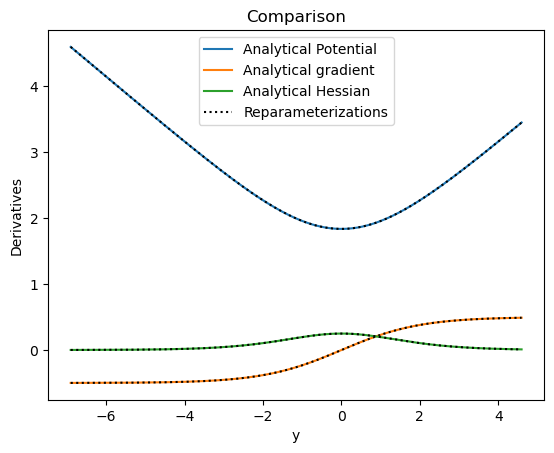

In [4]:
fig5, ax5 = plt.subplots()

# Plot potential
ax5.plot(y, -np.log(logit_beta_pdf(y)), label='Analytical Potential')
ax5.plot(y, v, linestyle='dotted', c='k')

# Plot gradient
ax5.plot(y, grad_V_y(y), label='Analytical gradient')
ax5.plot(y, gv, linestyle='dotted', c='k')

# Plot Hessian
ax5.plot(y, hess_V_y(y).squeeze(), label='Analytical Hessian')
ax5.plot(y, hv.squeeze(), linestyle='dotted', c='k', label='Reparameterizations')

ax5.set_title('Comparison')
ax5.set_xlabel('y')
ax5.set_ylabel('Derivatives')
ax5.legend()

In [10]:

# Do my results agree with what I've coded up previously?
y_ = logit(sigma_inv(x, a, b))

def getUnboundedPotential(eta, mlpt_X, gmlpt_X, Hmlpt_X, lower_bound, upper_bound):
    DoF = 1
    delta = upper_bound - lower_bound
    phi =  delta / (4 * jnp.cosh(eta / 2) ** 2)
    mlpt_Y = mlpt_X - jnp.sum(jnp.log(phi), axis=1)
    gmlpt_Y = gmlpt_X * phi + jnp.tanh(eta / 2)
    Hmlpt_Y = Hmlpt_X * contract('Ni,Nj -> Nij', phi, phi)
    Hmlpt_Y = Hmlpt_Y.at[:, jnp.arange(DoF), jnp.arange(DoF)].add(2 * phi / delta)
    return mlpt_Y, gmlpt_Y, Hmlpt_Y

v_y_test, g_v_y_test, h_v_y_test = getUnboundedPotential(y, V_x(x), grad_V_x(x), hess_V_x(x), a, b)

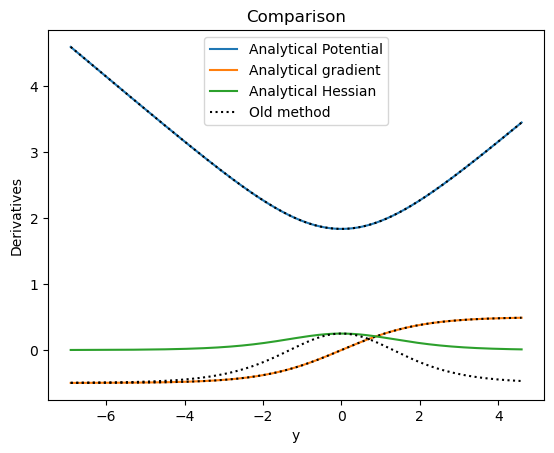

In [13]:
fig6, ax6 = plt.subplots()

# Plot potential
ax6.plot(y, -np.log(logit_beta_pdf(y)), label='Analytical Potential')
ax6.plot(y, v_y_test, linestyle='dotted', c='k')

# Plot gradient
ax6.plot(y, grad_V_y(y), label='Analytical gradient')
ax6.plot(y, g_v_y_test, linestyle='dotted', c='k')

# Plot Hessian
ax6.plot(y, hess_V_y(y).squeeze(), label='Analytical Hessian')
ax6.plot(y, h_v_y_test.squeeze(), linestyle='dotted', c='k', label='Old method')

ax6.set_title('Comparison')
ax6.set_xlabel('y')
ax6.set_ylabel('Derivatives')
ax6.legend()

In [12]:
v_y_test

Array([4.59910778, 4.25553871, 4.05414145, 3.9112172 , 3.80039484,
       3.70989998, 3.63344303, 3.5672662 , 3.50894401, 3.45681957,
       3.40971059, 3.36674387, 3.3272561 , 3.29073158, 3.25676141,
       3.22501591, 3.1952254 , 3.16716643, 3.14065183, 3.11552322,
       3.09164543, 3.06890212, 3.0471925 , 3.02642864, 3.00653337,
       2.98743861, 2.96908398, 2.9514157 , 2.93438563, 2.91795056,
       2.90207149, 2.88671317, 2.87184358, 2.85743359, 2.84345657,
       2.82988817, 2.81670604, 2.8038896 , 2.79141988, 2.77927936,
       2.76745181, 2.75592218, 2.74467647, 2.73370166, 2.72298559,
       2.71251693, 2.70228505, 2.69228002, 2.68249249, 2.67291371,
       2.66353542, 2.65434988, 2.64534975, 2.63652814, 2.6278785 ,
       2.61939467, 2.61107079, 2.60290133, 2.59488102, 2.58700487,
       2.57926814, 2.57166631, 2.56419508, 2.55685036, 2.54962824,
       2.54252501, 2.5355371 , 2.52866111, 2.5218938 , 2.51523206,
       2.5086729 , 2.50221347, 2.49585105, 2.489583  , 2.48340